## 0. Import dependencies

In [1]:
import os
import sys

import re
import pandas as pd
import networkx as nx
import tqdm
import random
import pickle

# Determine the project root directory for relative imports
try:
    # This will work in scripts where __file__ is defined
    current_dir = os.path.dirname(os.path.abspath(__file__))
    # Assuming "src" is parallel to the script folder
    project_root = os.path.abspath(os.path.join(current_dir, ".."))
except NameError:
    # In notebooks __file__ is not defined: assume we're in notebooks/riziv_dataset/
    project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))

src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Local application imports

## 1. Load data

In [2]:
# Define the path to the BSARD dataset files
BSARD_data_path = os.path.join(project_root, "data", "BSARD_dataset")

bsard_corpus = pd.read_csv(os.path.join(BSARD_data_path, 'bsard_corpus.csv'))

In [3]:
bsard_corpus.head(3)

,id,reference,article,law_type,code,book,part,act,chapter,section,subsection,description
0,1,"Art. 1.1.1, Code Bruxellois de l'Air, du Clima...",Le présent Code règle une matière visée à l'ar...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Généralités,NaN,NaN,NaN,"Dispositions communes, Généralités"
1,2,"Art. 1.1.2, Code Bruxellois de l'Air, du Clima...",Le présent Code transpose en Région de Bruxell...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Généralités,NaN,NaN,NaN,"Dispositions communes, Généralités"
2,3,"Art. 1.2.1, Code Bruxellois de l'Air, du Clima...",Le présent Code poursuit les objectifs suivant...,regional,"Code Bruxellois de l'Air, du Climat et de la M...",Dispositions communes,NaN,Objectifs,NaN,NaN,NaN,"Dispositions communes, Objectifs"


In [4]:
#bsard_corpus["code"].value_counts()

In [5]:
#bsard_corpus.iloc[1]

In [6]:
#bsard_corpus.iloc[9999]['reference']

In [7]:
#bsard_corpus["chapter"].value_counts()

## 2.

In [8]:
# Patrones para cada sección
PATTERNS = {
    "Book":    re.compile(r"(Livre\s+[^\),]+)"),
    "Title":   re.compile(r"(Titre\s+[^\),]+)"),
    "Chapter": re.compile(r"(Chapitre\s+[^\),]+)"),
    "Section": re.compile(r"(Section\s+[^\),]+)"),
}

def parse_citation(text):
    # 1) Article y Act
    article, rest = [s.strip() for s in text.split(",", 1)]
    # 2) Act (antes de paréntesis) y contenido interno de ()
    act_part, *paren = rest.split("(", 1)
    act = act_part.strip()
    inside = paren[0].rstrip(")") if paren else ""
    # 3) Para cada campo, buscar con su regex
    result = {
        "Article": article,
        "Act": act,
        "Book": None,
        "Title": None,
        "Chapter": None,
        "Section": None,
    }
    for key, pattern in PATTERNS.items():
        m = pattern.search(inside)
        if m:
            result[key] = m.group(1).strip()
    return result

In [9]:
parsed_art = []
parsed_act = []
parsed_book = []
parsed_title = []
parsed_chapter = []
parsed_section = []

for i in bsard_corpus['reference']:
    parsed_citation = parse_citation(i) 
    parsed_art.append(parsed_citation['Article'])
    parsed_act.append(parsed_citation['Act'])
    parsed_book.append(parsed_citation['Book'])
    parsed_title.append(parsed_citation['Title'])
    parsed_chapter.append(parsed_citation['Chapter'])
    parsed_section.append(parsed_citation['Section'])

In [10]:
bsard_corpus['parsed_art'] = parsed_art
bsard_corpus['parsed_act'] = parsed_act
bsard_corpus['parsed_book'] = parsed_book
bsard_corpus['parsed_title'] = parsed_title
bsard_corpus['parsed_chapter'] = parsed_chapter
bsard_corpus['parsed_section'] = parsed_section


In [11]:
bsard_corpus_lean = bsard_corpus[['id', 'parsed_act', 'parsed_book', 'parsed_title', 'parsed_chapter', 'parsed_section', 'parsed_art', 'article']]
bsard_corpus_lean

,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,None,None,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,None,None,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ..."
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,None,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ..."
...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,None,Titre VII,None,None,Art. 194,La ville de Bruxelles est la capitale de la Be...
22629,22630,La Constitution,None,Titre VIII,None,None,Art. 195,Le pouvoir législatif fédéral a le droit de dé...
22630,22631,La Constitution,None,Titre VIII,None,None,Art. 196,Aucune révision de la Constitution ne peut êtr...
22631,22632,La Constitution,None,Titre VIII,None,None,Art. 197,"Pendant une régence, aucun changement ne peut ..."


In [12]:
bsard_corpus_lean['parsed_book'].fillna('not_applicable', inplace=True)
bsard_corpus_lean

C:\Users\Usuario\AppData\Local\Temp\ipykernel_21324\3344348123.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  bsard_corpus_lean['parsed_book'].fillna('not_applicable', inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21324\3344348123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsard_corpus_lean['parsed_book'].fillna('no

,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,None,None,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,None,None,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ..."
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,None,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ..."
...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,not_applicable,Titre VII,None,None,Art. 194,La ville de Bruxelles est la capitale de la Be...
22629,22630,La Constitution,not_applicable,Titre VIII,None,None,Art. 195,Le pouvoir législatif fédéral a le droit de dé...
22630,22631,La Constitution,not_applicable,Titre VIII,None,None,Art. 196,Aucune révision de la Constitution ne peut êtr...
22631,22632,La Constitution,not_applicable,Titre VIII,None,None,Art. 197,"Pendant une régence, aucun changement ne peut ..."


In [27]:
bsard_corpus_lean[bsard_corpus_lean['id'].isin([12012,12030,12031,12032,12033,12034,12035])]


,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article,act_code,book_code,act_book_code,article_code
12011,12012,Code Wallon de l'Habitation Durable,not_applicable,Titre I,Chapitre I,None,Art. 1,"Au sens du présent Code, on entend par :1° bât...",21,0,21.0,21.0.1
12029,12030,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 9,La présente section s'applique aux logements c...,21,0,21.0,21.0.19
12030,12031,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 10,Avant toute mise en location d'un logement vis...,21,0,21.0,21.0.20
12031,12032,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 10bis,Avant toute mise en location d'une habitation ...,21,0,21.0,21.0.21
12032,12033,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 11,Le permis de location est délivré au bailleur ...,21,0,21.0,21.0.22
12033,12034,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 12,L'habitationne respectant pas les conditions f...,21,0,21.0,21.0.23
12034,12035,Code Wallon de l'Habitation Durable,not_applicable,Titre II,Chapitre I,Section 3,Art. 13,En cas de non-respect des conditions fixées pa...,21,0,21.0,21.0.24


In [14]:
from tqdm.auto import tqdm   # auto → notebook bar if available, else console

# --- first loop: add Code nodes --------------------------------------------
G = nx.DiGraph()

unique_codes = bsard_corpus_lean['parsed_act'].unique()
code_dict = {}

for code_id, code_name in enumerate(tqdm(unique_codes,
                                         desc="Building Code nodes"), start=1):
    code_dict[code_name] = str(code_id)
    G.add_node(str(code_id), node_type="Act", code_title=code_name)

# map column once the dictionary is ready
bsard_corpus_lean['act_code'] = bsard_corpus_lean['parsed_act'].map(code_dict)

## --- second loop: add Book nodes -------------------------------------------
act_books = {}
book_code = []
for row in bsard_corpus_lean.iterrows():

    act_code = row[1]['act_code']
    book = row[1]['parsed_book']

    if act_code not in act_books:
        act_books[act_code] = {"counter": 0, "not_applicable": 0}

    if book not in act_books[act_code].keys():
        act_books[act_code][book] = act_books[act_code]["counter"] + 1
        act_books[act_code]["counter"] += 1

    elif book in act_books[act_code].keys():
        pass

    book_code.append(act_books[act_code][book])

bsard_corpus_lean['book_code'] = book_code

bsard_corpus_lean['act_book_code'] = bsard_corpus_lean['act_code'].astype(str) + '.' + bsard_corpus_lean['book_code'].astype(str)


for act_book_code in tqdm(bsard_corpus_lean['act_book_code'].unique(),
                     desc="Building Book nodes"):


    G.add_node(act_book_code, node_type="Book", book_title=bsard_corpus_lean[bsard_corpus_lean['act_book_code'] == act_book_code]['parsed_book'].unique()[0])
    act_code = bsard_corpus_lean[bsard_corpus_lean['act_book_code'] == act_book_code]['act_code'].unique()[0]

    G.add_edge(str(act_code), act_book_code, relation="CONTAINS")
    G.add_edge(act_book_code, str(act_code), relation="BELONGS_TO")

# --- third loop: add Article nodes -------------------------------------------
act_book_codes = {}
article_codes = []

for row in bsard_corpus_lean.iterrows():

    act_book_code = row[1]['act_book_code']
    if act_book_code not in act_book_codes:
        act_book_codes[act_book_code] = 0

    article_codes.append(act_book_codes[act_book_code]+1)
    act_book_codes[act_book_code] += 1

bsard_corpus_lean['article_code'] = bsard_corpus_lean['act_code'].astype(str) + '.' + bsard_corpus_lean['book_code'].astype(str) + '.' + pd.Series(article_codes).astype(str)

for row in bsard_corpus_lean.iterrows():
    G.add_node(row[1]['article_code'], node_type="Article", article_title=row[1]['parsed_art'], article_text=row[1]['article'])

    G.add_edge(row[1]['article_code'], row[1]['act_book_code'], relation="CONTAINS")
    G.add_edge(row[1]['act_book_code'], row[1]['article_code'], relation="BELONGS_TO")

c:\Users\Usuario\pyenvs\python311_graphsage\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Building Code nodes: 100%|██████████| 35/35 [00:00<?, ?it/s]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21324\2923448308.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bsard_corpus_lean['act_code'] = bsard_corpus_lean['parsed_act'].map(code_dict)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_21324\2923448308.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [15]:
bsard_corpus_lean


,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article,act_code,book_code,act_book_code,article_code
0,1,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.1,Le présent Code règle une matière visée à l'ar...,1,1,1.1,1.1.1
1,2,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 1er,None,None,Art. 1.1.2,Le présent Code transpose en Région de Bruxell...,1,1,1.1,1.1.2
2,3,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 2,None,None,Art. 1.2.1,Le présent Code poursuit les objectifs suivant...,1,1,1.1,1.1.3
3,4,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 3,None,None,Art. 1.3.1,"Au sens du présent Code, il faut entendre par ...",1,1,1.1,1.1.4
4,5,"Code Bruxellois de l'Air, du Climat et de la M...",Livre 1er,Titre 4,Chapitre 1er,None,Art. 1.4.1,"Le plan régional Air-Climat-énergie, ci-après ...",1,1,1.1,1.1.5
...,...,...,...,...,...,...,...,...,...,...,...,...
22628,22629,La Constitution,not_applicable,Titre VII,None,None,Art. 194,La ville de Bruxelles est la capitale de la Be...,35,0,35.0,35.0.204
22629,22630,La Constitution,not_applicable,Titre VIII,None,None,Art. 195,Le pouvoir législatif fédéral a le droit de dé...,35,0,35.0,35.0.205
22630,22631,La Constitution,not_applicable,Titre VIII,None,None,Art. 196,Aucune révision de la Constitution ne peut êtr...,35,0,35.0,35.0.206
22631,22632,La Constitution,not_applicable,Titre VIII,None,None,Art. 197,"Pendant une régence, aucun changement ne peut ...",35,0,35.0,35.0.207


In [16]:
#node_id = '0'
#print(G.nodes[node_id])  # Muestra todos los atributos del nodo

In [17]:
# Inspect the resulting graph
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# Print a few sample edges with their relations
for u, v, data in list(G.edges(data=True))[:10]:
    print(f"{u} → {v}, relation={data['relation']}")

Number of nodes: 22818
Number of edges: 45566
1 → 1.1, relation=CONTAINS
1 → 1.2, relation=CONTAINS
1 → 1.3, relation=CONTAINS
1 → 1.4, relation=CONTAINS
2 → 2.0, relation=CONTAINS
3 → 3.0, relation=CONTAINS
4 → 4.0, relation=CONTAINS
4 → 4.1, relation=CONTAINS
4 → 4.2, relation=CONTAINS
4 → 4.3, relation=CONTAINS


In [18]:
import matplotlib.pyplot as plt

def visualize_node_1hop(G: nx.DiGraph, node_id: str, figsize=(12, 8)):
    """
    Visualize a node and its 1‑hop neighborhood in a hierarchy graph.

    Nodes are colored by their 'level' attribute:
      - Central node: red
      - Act: gold
      - Book: orange
      - Title: lightblue
      - Chapter: green
      - Section: teal
      - Article: purple

    Edges are drawn and labeled according to their 'relation' attribute:
      - CONTAINS: black, label="contains"
      - BELONGS_TO: gray, label="belongs to"
    """
    # Gather the node and its immediate predecessors & successors
    preds = list(G.predecessors(node_id))
    succs = list(G.successors(node_id))
    sub_nodes = {node_id, *preds, *succs}
    subG = G.subgraph(sub_nodes)

    plt.figure(figsize=figsize)
    # Force a consistent layout for clarity
    pos = nx.spring_layout(subG, k=1.0, iterations=50, seed=42)

    # Color mapping for levels
    level_colors = {
        "Act": "gold",
        "Book": "orange",
        "Title": "lightblue",
        "Chapter": "green",
        "Section": "teal",
        "Article": "purple"
    }

    # Draw all nodes, colored by level
    for level, color in level_colors.items():
        nodes_of_level = [
            n for n, attrs in subG.nodes(data=True)
            if attrs.get("level") == level and n != node_id
        ]
        nx.draw_networkx_nodes(
            subG, pos,
            nodelist=nodes_of_level,
            node_color=color,
            node_size=1200,
            label=level
        )

    # Draw the central node on top
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=[node_id],
        node_color="red",
        node_size=1500,
        label="Central"
    )

    # Draw edges by relation type
    relation_styles = {
        "CONTAINS":    {"color": "black", "label": "contains"},
        "BELONGS_TO":  {"color": "gray",  "label": "belongs to"}
    }
    # We'll collect labels separately so they don't overlap too badly
    edge_labels = {}

    for (u, v, attrs) in subG.edges(data=True):
        rel = attrs.get("relation")
        style = relation_styles.get(rel, {})
        nx.draw_networkx_edges(
            subG, pos,
            edgelist=[(u, v)],
            edge_color=style.get("color", "black"),
            arrows=True,
            arrowsize=20,
            connectionstyle="arc3,rad=0.1"
        )
        # position label near the middle of the edge
        edge_labels[(u, v)] = style.get("label", rel.lower())

    # Draw edge labels
    nx.draw_networkx_edge_labels(
        subG, pos,
        edge_labels=edge_labels,
        font_size=9,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        label_pos=0.5
    )

    # Draw node labels (just show the node_id or you could use attrs['label'])
    labels = {n: n.split("|", 1)[-1] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=8)

    # Add a legend for node colors
    handles = []
    for level, color in level_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  label=level,
                                  markerfacecolor=color, markersize=10))
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              label="Central", markerfacecolor='red', markersize=10))
    plt.legend(handles=handles, loc="upper left", bbox_to_anchor=(1, 1))

    plt.title(f"1‑hop neighborhood of node: {node_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [19]:
G.nodes['28.2.198']

{'node_type': 'Article',
 'article_title': 'Art. L2212-75',
 'article_text': "Le président, le ou les vice-présidents et les membres du bureau du conseil provincial, ainsi que les présidents de commissions instituées en application de l'article L2212-14, ne peuvent être membres du collège provincial."}

In [20]:
list(G.neighbors('28.2.198'))


['28.2']

In [21]:
bsard_corpus_lean[bsard_corpus_lean['article_code'] == '28.2.198']


,id,parsed_act,parsed_book,parsed_title,parsed_chapter,parsed_section,parsed_art,article,act_code,book_code,act_book_code,article_code
17532,17533,Code de la Démocratie Locale et de la Décentra...,Livre II,Titre Ier,Chapitre II,Section 7,Art. L2212-75,"Le président, le ou les vice-présidents et les...",28,2,28.2,28.2.198


Randomly selected node: 32.14


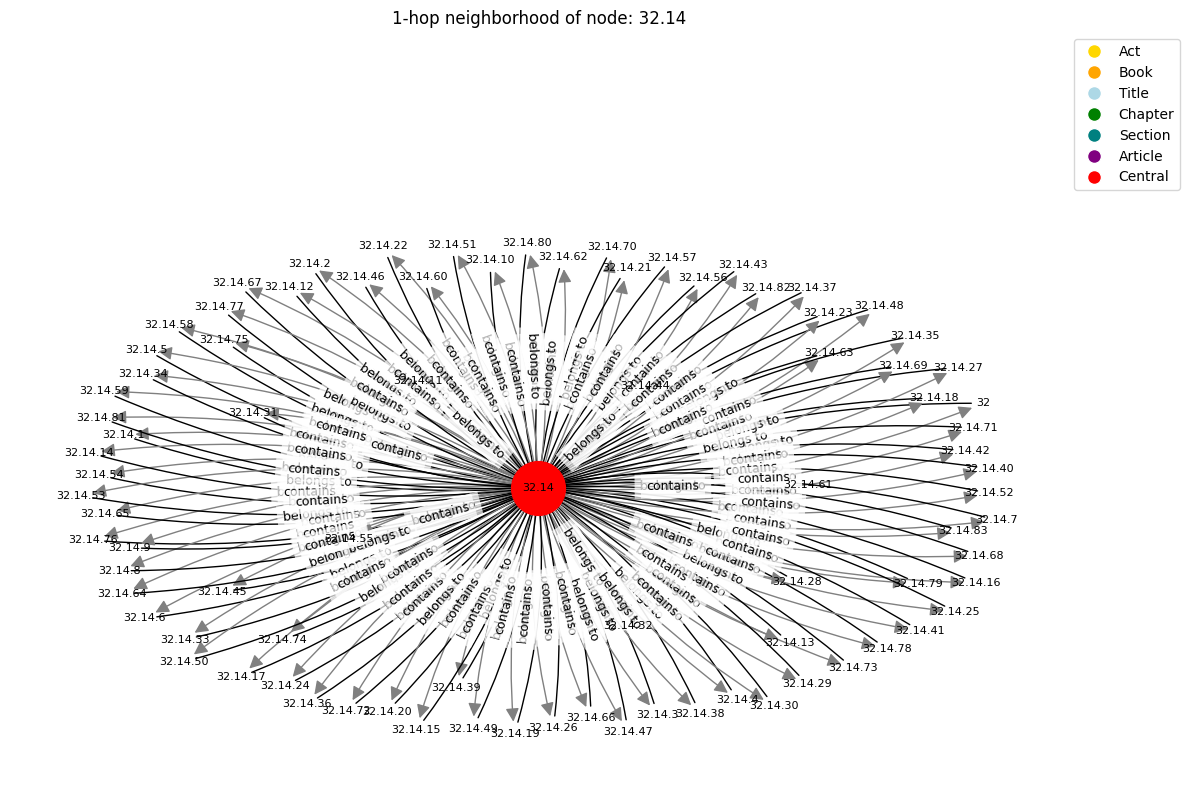

In [22]:
# Select a random node from the graph
random_node = random.choice(list(G.nodes()))
#print(f"node type: {G.nodes[random_node]['node_type']}")

while G.nodes[random_node]['node_type'] == 'Article':
    #print(f"node type: {G.nodes[random_node]['node_type']}")
    random_node = random.choice(list(G.nodes()))

# Print it (so you know which one it is), then visualize its 1‑hop neighborhood
print(f"Randomly selected node: {random_node}")
visualize_node_1hop(G, random_node)

In [23]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_node_2hop(G: nx.DiGraph, node_id: str, figsize=(15, 10)):
    """
    Visualize a node, its 1‑hop and 2‑hop neighbors in a hierarchy graph.

    Nodes are colored by their 'level' attribute:
      - Central node: red
      - Act: gold
      - Book: orange
      - Title: lightblue
      - Chapter: green
      - Section: teal
      - Article: purple

    Edges are drawn and labeled according to their 'relation' attribute:
      - CONTAINS: black, label="contains"
      - BELONGS_TO: gray, label="belongs to"
    """
    # 1-hop neighbors
    first_hop = set(G.predecessors(node_id)) | set(G.successors(node_id))
    # 2-hop neighbors
    second_hop = set()
    for nbr in first_hop:
        second_hop |= set(G.predecessors(nbr))
        second_hop |= set(G.successors(nbr))
    # exclude the central node and 1-hop from 2-hop
    second_hop -= first_hop
    second_hop.discard(node_id)

    # Build subgraph of central + 1-hop + 2-hop
    sub_nodes = {node_id} | first_hop | second_hop
    subG = G.subgraph(sub_nodes)

    plt.figure(figsize=figsize)
    pos = nx.spring_layout(subG, k=1.5, iterations=50, seed=42)

    # Color mapping for levels
    level_colors = {
        "Act": "gold",
        "Book": "orange",
        "Title": "lightblue",
        "Chapter": "green",
        "Section": "teal",
        "Article": "purple"
    }

    # Draw 2-hop neighbors (smaller)
    two_hop_nodes = [n for n in second_hop]
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=two_hop_nodes,
        node_color=[level_colors.get(subG.nodes[n].get("level"), "gray") for n in two_hop_nodes],
        node_size=600,
        alpha=0.5,
        label="2-hop"
    )

    # Draw 1-hop neighbors
    one_hop_nodes = [n for n in first_hop]
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=one_hop_nodes,
        node_color=[level_colors.get(subG.nodes[n].get("level"), "gray") for n in one_hop_nodes],
        node_size=1200,
        alpha=0.8,
        label="1-hop"
    )

    # Draw central node last (on top)
    nx.draw_networkx_nodes(
        subG, pos,
        nodelist=[node_id],
        node_color="red",
        node_size=2000,
        label="Central"
    )

    # Draw edges
    rel_styles = {
        "CONTAINS":   {"color": "black", "label": "contains"},
        "BELONGS_TO": {"color": "gray",  "label": "belongs to"}
    }
    edge_labels = {}
    for u, v, attrs in subG.edges(data=True):
        rel = attrs.get("relation")
        style = rel_styles.get(rel, {"color": "black", "label": rel.lower()})
        nx.draw_networkx_edges(
            subG, pos,
            edgelist=[(u, v)],
            edge_color=style["color"],
            arrows=True,
            arrowsize=15,
            connectionstyle="arc3,rad=0.1"
        )
        edge_labels[(u, v)] = style["label"]

    # Draw edge labels
    nx.draw_networkx_edge_labels(
        subG, pos,
        edge_labels=edge_labels,
        font_size=8,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7),
        label_pos=0.5
    )

    # Node labels: show just the value part (after the first '|')
    labels = {n: n.split("|", 1)[-1] for n in subG.nodes()}
    nx.draw_networkx_labels(subG, pos, labels, font_size=8)

    # Build legend
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', label='Central',   markerfacecolor='red',        markersize=10),
        plt.Line2D([0], [0], marker='o', color='w', label='1-hop',     markerfacecolor='lightgray', markersize=8, alpha=0.8),
        plt.Line2D([0], [0], marker='o', color='w', label='2-hop',     markerfacecolor='lightgray', markersize=6, alpha=0.5),
    ]
    for level, color in level_colors.items():
        handles.append(plt.Line2D([0], [0], marker='o', color='w',
                                  label=level, markerfacecolor=color, markersize=8))
    plt.legend(handles=handles, loc='upper left', bbox_to_anchor=(1,1))

    plt.title(f"2‑hop neighborhood of node: {node_id}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()


Randomly selected node: 6.0.95


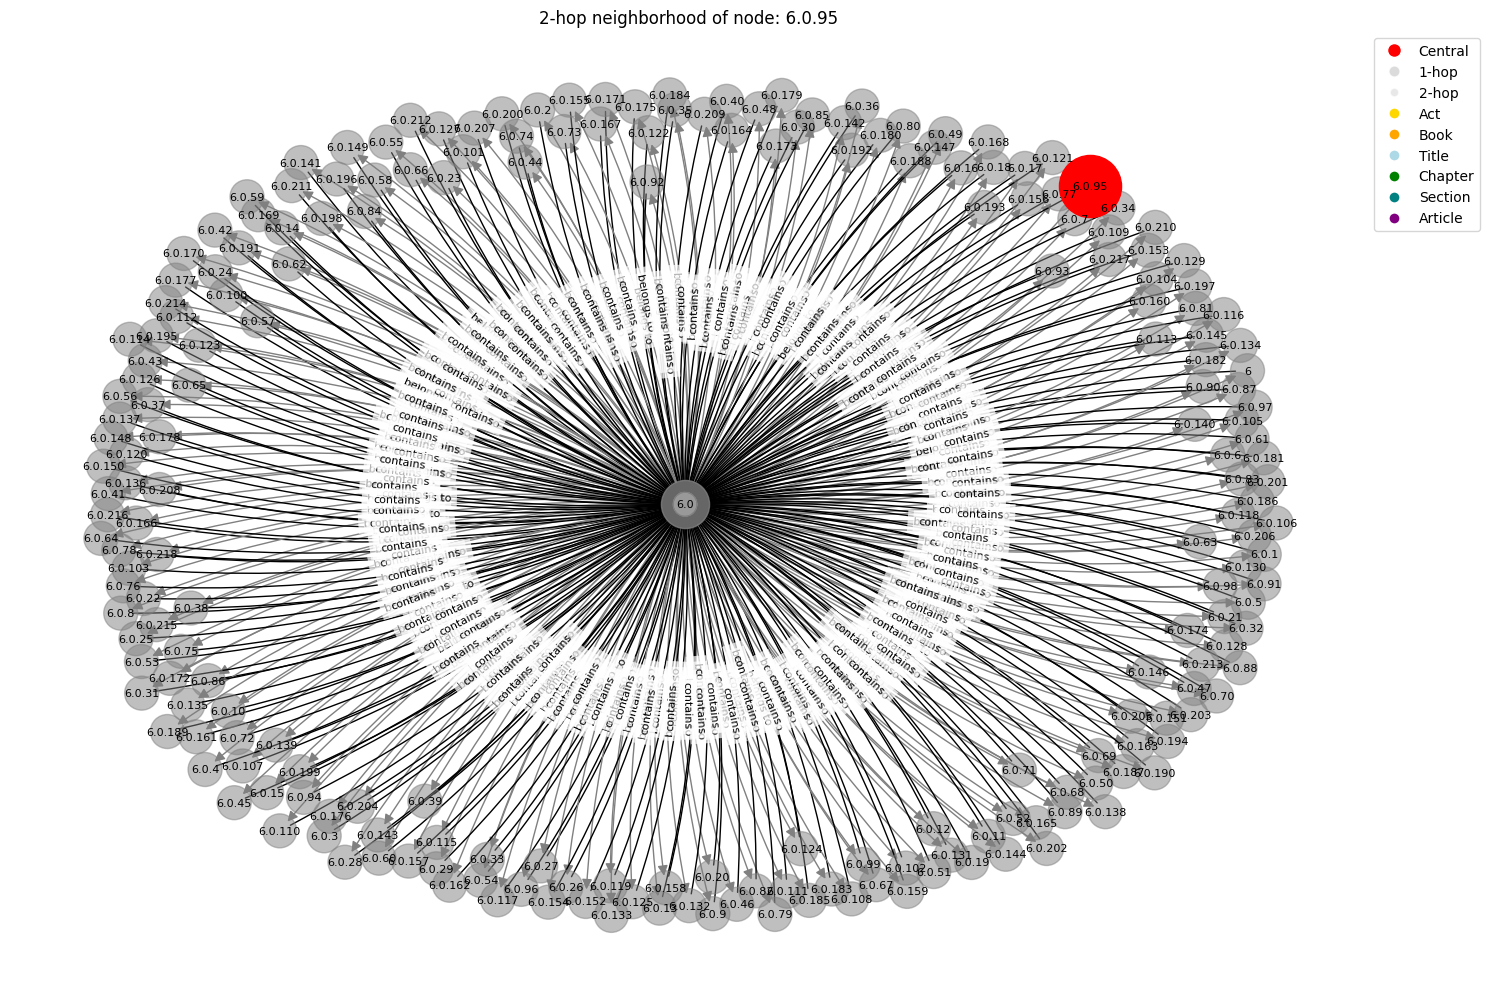

In [24]:


# Select a random node from the graph
random_node = random.choice(list(G.nodes()))

# Print it (so you know which one it is), then visualize its 1‑hop neighborhood
print(f"Randomly selected node: {random_node}")
visualize_node_2hop(G, random_node)

## 3.

In [25]:
import pickle

with open(os.path.join(BSARD_data_path, "base_document_graph.pkl"), 'wb') as f:
    pickle.dump(G, f)

In [29]:
bsard_corpus_lean.to_csv(os.path.join(BSARD_data_path, "bsard_corpus_lean.csv"))